In [1]:
from web3 import Web3
import pandas as pd
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import torch

In [2]:
web3 = Web3(Web3.HTTPProvider("https://intensive-sly-mountain.quiknode.pro/a3f5256d7f2af6541d483cce3f1d49c94c01879e/"))
print(web3.is_connected())

True


In [3]:
df_insertion = pd.read_csv ('../data/insertion_attacks.csv', delimiter=',')
print('# of insertion: ', len(df_insertion))

# of insertion:  196691


In [4]:
def get_max_block_number() -> int:
    return int(df_insertion["Block Number"].max())

In [5]:
df_insertion[df_insertion["Block Number"] >= get_max_block_number()]

,Block Number,First Attacker,Whale,Second Attacker,First-Whale Gas Price Delta,Whale-Second Gas Price Delta,Profit,Cost,Interface,Exchange,Token,Bot,Bot Cluster ID
195114,11299998,0xeD1cAa76a8cb7E671654A6c816a753acE6217BAE,0xf384aa91c1709Ec28b7422A2897E74f2d61036Cd,0xeD1cAa76a8cb7E671654A6c816a753acE6217BAE,10.09376,0.0,5.022881,4.400952,bot,Uniswap V2,yfi.group,0xEB46faa47A6A52519839A2e52c7b28a2Db17651e,37.0


In [6]:
def get_gas_prices_from_last_100_blocks(web3: Web3) -> list[int]:
    
    highest_block = get_max_block_number()    
    
    gas_prices = []
    for i in range(100):
        block = web3.eth.get_block(highest_block - i, full_transactions=True)
        
        for transaction in block.transactions:
            gas_prices.append(transaction["gasPrice"] / 10**18) # convertion from wei to eth
        
    return gas_prices

In [7]:
gas_prices_last_100_blocks = get_gas_prices_from_last_100_blocks(web3)

In [8]:
train_size = int(len(gas_prices_last_100_blocks) * 0.8)

train = gas_prices_last_100_blocks[:train_size]
test = gas_prices_last_100_blocks[train_size:]

mean_train = np.mean(train, axis=0)
std_train = np.std(train, axis=0)

def standardize(X, mean, std):
    return (X - mean) / std

# standardize both X_train and X_val
train = standardize(train, mean_train, std_train)
test = standardize(test, mean_train, std_train)

In [9]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback-1):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback + 1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X).view(len(X), 1, lookback).type(torch.float32), torch.tensor(y).view(len(y), 1).type(torch.float32)

lookback = 15
X_train, y_train = create_dataset(train, lookback)
X_test, y_test = create_dataset(test, lookback)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([14023, 1, 15]) torch.Size([14023, 1])
torch.Size([3494, 1, 15]) torch.Size([3494, 1])


C:\Users\larsh\AppData\Local\Temp\ipykernel_10124\3670963011.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(X).view(len(X), 1, lookback).type(torch.float32), torch.tensor(y).view(len(y), 1).type(torch.float32)


In [10]:
# source https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fully_connected = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        return  self.fully_connected(out[:, -1, :])

In [19]:
# define parameters
epochs = 100
nr_input_features = lookback
hidden_neurons = 100
hidden_layer = 1
output = 1
learning_rate = 0.001
momentum = 0.9
batch_size = 100

model = LSTM(nr_input_features, hidden_neurons, hidden_layer, output)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
loss_fn = torch.nn.MSELoss()

loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)

train_mse_loss = []
test_mse_loss = []

for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_mse = loss_fn(y_pred, y_train)
        train_mse_loss.append(train_mse.item())
        y_pred = model(X_test)
        test_mse = loss_fn(y_pred, y_test)
        test_mse_loss.append(test_mse.item())
    print("Epoch %d: train MSE %.4f, test MSE %.4f" % (epoch, train_mse, test_mse))

Epoch 0: train MSE 0.8874, test MSE 0.4715
Epoch 10: train MSE 0.7133, test MSE 0.3300
Epoch 20: train MSE 0.6978, test MSE 0.3245
Epoch 30: train MSE 0.6938, test MSE 0.3246
Epoch 40: train MSE 0.6912, test MSE 0.3241
Epoch 50: train MSE 0.6894, test MSE 0.3237
Epoch 60: train MSE 0.6880, test MSE 0.3236
Epoch 70: train MSE 0.6865, test MSE 0.3233
Epoch 80: train MSE 0.6858, test MSE 0.3239
Epoch 90: train MSE 0.6847, test MSE 0.3234
Epoch 100: train MSE 0.6837, test MSE 0.3227
Epoch 110: train MSE 0.6835, test MSE 0.3235
Epoch 120: train MSE 0.6827, test MSE 0.3232
Epoch 130: train MSE 0.6820, test MSE 0.3231
Epoch 140: train MSE 0.6819, test MSE 0.3241
Epoch 150: train MSE 0.6810, test MSE 0.3233
Epoch 160: train MSE 0.6804, test MSE 0.3228
Epoch 170: train MSE 0.6800, test MSE 0.3226
Epoch 180: train MSE 0.6802, test MSE 0.3236
Epoch 190: train MSE 0.6796, test MSE 0.3230


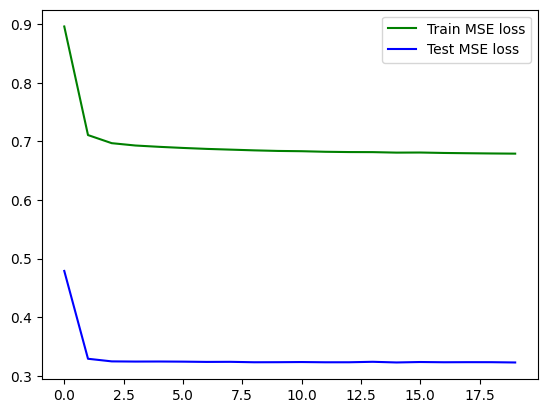

In [15]:
plt.plot(train_mse_loss, "g-", label="Train MSE loss")
plt.plot(test_mse_loss, "b-", label="Test MSE loss")
plt.legend()
plt.show()

In [20]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(gas_prices_last_100_blocks) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1]
    train_plot[lookback:train_size - 1] = model(X_train)[:, -1]
    # shift test predictions for plotting
    test_plot = np.ones_like(gas_prices_last_100_blocks) * np.nan
    test_plot[train_size+lookback:len(gas_prices_last_100_blocks) -1] = model(X_test)[:, -1]

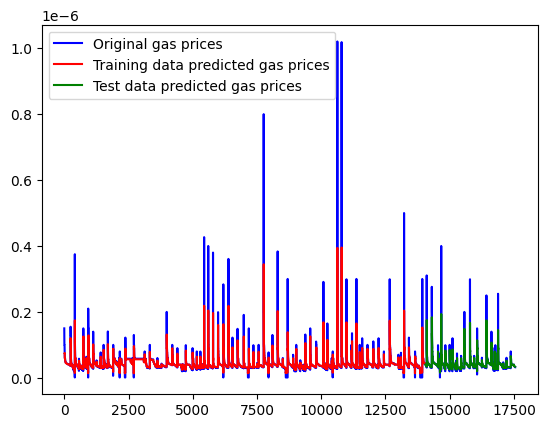

In [21]:
def transform_before_standardization(X, mean_train, std_train):
    return (X * std_train) + mean_train

train_plot = transform_before_standardization(train_plot, mean_train, std_train)
test_plot = transform_before_standardization(test_plot, mean_train, std_train)

plt.plot(gas_prices_last_100_blocks, c='b', label="Original gas prices")
plt.plot(train_plot, c='r', label="Training data predicted gas prices")
plt.plot(test_plot, c='g', label="Test data predicted gas prices")
plt.legend()
plt.show()

In [28]:
# save model
model_scripted = torch.jit.script(model)
model_scripted.save('./lstm-feature-7.pt')

# save mean and std
torch.save(mean_train, 'mean_train.pt')
torch.save(std_train, 'std_train.pt')